In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from scipy import sparse
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import rc

rc("text", usetex=True)
import os, sys
from joblib import Parallel, delayed
from math import sqrt
from collections import Counter

sys.path.append(os.path.abspath(os.path.join("../workflow/")))
import utils

# Data

In [22]:
contact_data = "/home/skojaku/projects/contact-tracing/data/dropbox/shared_data/sensible-dtu/input/bt_symmetric.csv"
contact_table = pd.read_csv(contact_data, sep=",")
display(contact_table.head(3))

log_root = "/home/skojaku/projects/contact-tracing/data/dropbox/shared_data/sensible-dtu/output/sir"
logs = pd.read_csv("{root}/r2.2_T5.1_logs.csv".format(root=log_root), sep=",")
display(logs.head(3))
logs.max()

,timestamp,user_a,user_b,rssi
0,0,0,-1,0
1,0,1,-1,0
2,0,2,-1,0


,id,elapsed,type,node,source
0,5234af10-a4e2-11ea-9776-a9fa96382311,227,r,289,NaN
1,5234af10-a4e2-11ea-9776-a9fa96382311,465,i,426,368.0
2,5234af10-a4e2-11ea-9776-a9fa96382311,479,i,184,426.0


id         b92957c0-a4e2-11ea-9776-a9fa96382311
elapsed                                   31776
type                                          r
node                                        566
source                                      565
dtype: object

# Make a contact list for each node

In [19]:
# COMMENT (Enys): you don't need to threshold the data, just use bluetooth-short-q60.csv.

rssi_threshold = -75

edge_table = contact_table[
    (contact_table["user_a"] >= 0)
    * (contact_table["user_b"] >= 0)
    * (contact_table["rssi"] >= rssi_threshold)
]

# Symmetrize the edges
edge_table = pd.concat(
    [
        edge_table.rename(columns={"user_a": "node", "user_b": "contact"}),
        edge_table.rename(columns={"user_b": "node", "user_a": "contact"}),
    ],
    ignore_index=True,
)

# Make a contact list for each node
contact_list = {
    i: edge for i, edge in edge_table.sort_values(by="timestamp").groupby("node")
}

# Construct the transmission tree

In [20]:
tree_list = []
N = logs["node"].max() + 1
for sim_id, sim_logs in logs.groupby("id"):
    se_event = sim_logs[sim_logs.type == "i"].dropna()
    tree = nx.from_pandas_edgelist(
        df=se_event,
        source="source",
        target="node",
        edge_attr="elapsed",
        create_using=nx.DiGraph,
    )

    # Find the root of the tree
    first_cases = [n for n, d in tree.in_degree() if d == 0]
    infected_time = dict(zip(first_cases, np.zeros(len(first_cases))))
    nx.set_node_attributes(tree, infected_time, "infected_time")

    infected_time = sim_logs[sim_logs.type == "i"][["node", "elapsed"]]
    infected_time = dict(zip(infected_time.node, infected_time.elapsed))
    nx.set_node_attributes(tree, infected_time, "infected_time")

    recovery_time = sim_logs[sim_logs.type == "r"][["node", "elapsed"]]
    recovery_time = dict(zip(recovery_time.node, recovery_time.elapsed))
    nx.set_node_attributes(tree, recovery_time, "recovery_time")

    tree_list += [tree]

# Functions for evaluating the transmission tree

In [21]:
def sample_infected(tree, t, p_sample):
    infected = [
        x[0]
        for x in tree.nodes(data=True)
        if (x[1]["infected_time"] <= t) and (t < x[1]["recovery_time"])
    ]
    # COMMENT (Enys): I am not sure this is the same as sampling everyone with probability p_sample.
    #  If p_sample * int(infected) < 1, you get 0 here, whereas there is a nonzero average number of sampled nodes for
    #  all p_sample > 0. Also, the average should be p_sample * int(infected) but this will not have that average.
    #  How about [x for x in infected if np.random.rand() < p_sample] ?
    return np.random.choice(
        infected, int(len(infected) * p_sample), replace=False
    ).astype(int)

def epidemic_size2elapse_time(tree, epidemic_size):
    """
    Compute the elapse time that reaches an epidemic size
    
    Parameters
    ----------
    tree : nx.DiGraph
        Transmission tree
    epidemic_size : int
        Epidemic size
        
    Returns
    -------
    t : int
        Elapse time
    """
    infected_time = np.sort([x[1]["infected_time"] for x in tree.nodes(data = True)])
    return infected_time[epidemic_size]

def case_isolation(tree, epidemic_size, p_sample):
    """
    Parameters
    ----------
    epidemic_size : int
        Minimum number of nodes above which the intervention is made.
    p_sample : sampling probability for the infected nodes.
    
    Returns
    -------
    list of isolated nodes
    t : time for intervention
    """
    # COMMENT (Enys): In my scripts, I modeled the intervention right at the time when the node was infected.
    #  Should I also do the intervention at a specific time regardless when the nodes were infected?
    t = epidemic_size2elapse_time(tree, epidemic_size)
    return sample_infected(tree, t, p_sample), t


def contact_tracing(tree, contact_list, epidemic_size, p_sample, p_t, p_r, trace_time_window, effective_contact_duration):
    """
    Parameters
    ----------
    tree : nx.DiGraph
        Transmission tree
    contact_list : dict
        Key: node id. Value: pd.DataFrame consisting of ``contact'' and ``timestamp'', where the contact
        is the ids of the node that have a contact.
    epidemic_size : int
        Minimum number of nodes above which the intervention is made.
    p_sample : sampling probability for the infected nodes.
    p_t : probability of conducting tracing for an infected node.
    p_r : probability that the parents and siblings are isolated.
    trace_time_window : int
        For an infected node sampled at time t, we first create a list of recent contacted nodes.
        To this end, we find nodes that have a contact with the node in question for at least ``effective_contact_duration'' during (t-``trace_time_window'', t].
        Note that time window is left open.
    effective_contact_duration : int
        We regard that a node has a contact with another node if one has been with the other 
        for at least ``effective_contact_duration''
    
    Returns
    -------
    list of isolated nodes
    t : time for intervention
    """
    
    # Calculate the time to conduct the intervention
    t = epidemic_size2elapse_time(tree, epidemic_size)

    # Sample infected individuals
    infected_sampled = sample_infected(tree, t, p_sample)

    traced_contact = []
    for node in infected_sampled:
        # COMMENT (Enys): What does this if statement do?
        if node not in tree or (len(list(tree.predecessors(node))) == 0):
            continue
        if np.random.rand() > p_t:  # skip contact tracing
            continue
            
        # Get all contacts between (t-trace_time_window, t] 
        contacts = contact_list[node] 
        contacts = contacts[ ((t-trace_time_window)<contacts["timestamp"]) * (contacts["timestamp"]<=t) ]
        
        # Remove non-frequent contacts
        freq = contacts["contact"].value_counts()
        recent_contact_list= (freq[freq >= effective_contact_duration]).index.values.tolist()
        
        #parent = list(tree.predecessors(node))[0]
        #siblings = list(tree.successors(parent))
        #recent_contact_list = [parent] + siblings
        for i in recent_contact_list:
            if np.random.random() < p_r:
                traced_contact += [i]

    traced_contact = np.unique(traced_contact)
    return list(
        set(list(infected_sampled.astype(int)) + list(traced_contact.astype(int)))
    ), t


def count_preventable_cases(tree, t_interv, t_eval, isolated_nodes):
    preventable_cases = []
    for node in isolated_nodes:
        if node not in tree:
            continue
        desc = [(x, tree.nodes[x]) for x in list(nx.descendants(tree, node))]
        preventable_cases += [
            x[0]
            for x in desc
            if (t_interv < x[1]["infected_time"]) and (x[1]["infected_time"] < t_eval)
        ]
    return list(set(preventable_cases))


def find_cases(tree, t_min, t_max):
    return [
        x[0]
        for x in tree.nodes(data=True)
        if (t_min < x[1]["infected_time"]) and (x[1]["infected_time"] < t_max)
    ]

# Compute the statistics for the interventions 

In [89]:
dt_eval = 5000

# Sampling prob. for infected individuals
p_sample_list = np.concatenate([np.linspace(0.01, 0.1, 10), np.linspace(0.2, 1.0, 9)])

# probability of conducting contact tracing for each sampled infected nodes
p_t = 1.0

# Probability that the parent or a sibling is isolated
p_r = 0.5

results = []
for p_sample in p_sample_list:

    # Contact tracing
    num_prevented = np.zeros(len(tree_list)) * np.nan
    num_isolated = np.zeros(len(tree_list)) * np.nan
    num_new_cases = np.zeros(len(tree_list)) * np.nan
    for i, tree in enumerate(tree_list):
        # COMMENT (Enys): t_interv is not defined anywhere.
        isolated_nodes = contact_tracing(tree, t_interv, p_sample, p_t, p_r)
        preventable_cases = count_preventable_cases(
            tree, t_interv, t_eval, isolated_nodes
        )
        new_cases = set(find_cases(tree, t_interv, t_eval))

        num_isolated[i] = len(isolated_nodes)
        num_prevented[i] = len(set(preventable_cases))
        num_new_cases[i] = len(new_cases)

    results += [
        pd.DataFrame(
            {
                "p_r": p_r,
                "p_sample": p_sample,
                "num_prevented": num_prevented,
                "num_isolated": num_isolated,
                "num_new_cases": num_new_cases,
                "intervention": "Contact tracing",
            }
        )
    ]

    # Case isolation
    num_prevented = np.zeros(len(tree_list)) * np.nan
    num_isolated = np.zeros(len(tree_list)) * np.nan
    num_new_cases = np.zeros(len(tree_list)) * np.nan
    for i, tree in enumerate(tree_list):
        isolated_nodes = case_isolation(tree, t_interv, p_sample)
        preventable_cases = count_preventable_cases(
            tree, t_interv, t_eval, isolated_nodes
        )
        new_cases = set(find_cases(tree, t_interv, t_eval))
        num_isolated[i] = len(isolated_nodes)
        num_prevented[i] = len(set(preventable_cases))
        num_new_cases[i] = len(new_cases)

    results += [
        pd.DataFrame(
            {
                "p_r": p_r,
                "p_sample": p_sample,
                "num_prevented": num_prevented,
                "num_isolated": num_isolated,
                "num_new_cases": num_new_cases,
                "intervention": "Case isolation",
            }
        )
    ]
result_table = pd.concat(results, ignore_index=True)

In [90]:
# Drop results with no new case
result_table = result_table[result_table["num_new_cases"] > 0]

result_table["f_num_prevented"] = result_table["num_prevented"] / np.maximum(
    1.0, result_table["num_new_cases"]
)

result_table["efficiency"] = result_table["num_prevented"] / np.maximum(
    result_table["num_isolated"], 1
)

result_table = result_table.rename(
    columns={"p_sample": "$p_s$", "f_num_prevented": "Preventable cases"}
)

# Plot

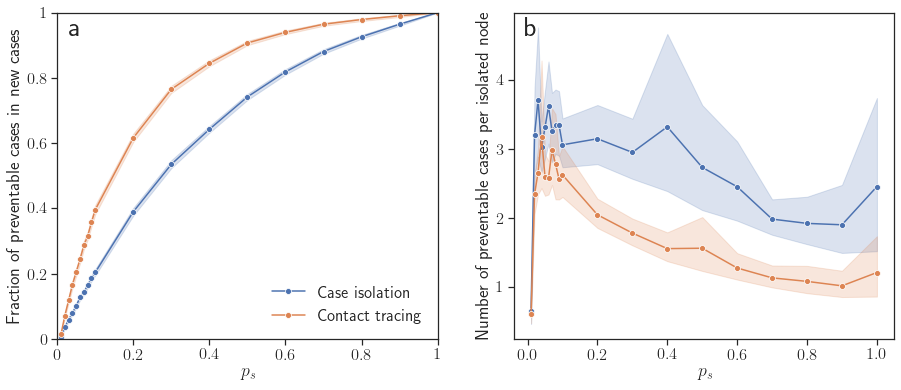

In [91]:
sns.set_style("white")
sns.set(font_scale=1.5)
sns.set_style("ticks")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for intervention, result in result_table.groupby("intervention"):
    sns.lineplot(
        data=result,
        x="$p_s$",
        y="Preventable cases",
        marker="o",
        label=intervention,
        ax=axes.flat[0],
    )

    sns.lineplot(
        data=result,
        x="$p_s$",
        y="efficiency",
        marker="o",
        label=intervention,
        ax=axes.flat[1],
    )

# Legend
axes.flat[0].legend(frameon=False, loc="lower right")
axes.flat[1].legend().remove()

# Labels
axes.flat[0].set_ylabel("Fraction of preventable cases in new cases")
axes.flat[1].set_ylabel("Number of preventable cases per isolated node")

# Ticks
xticks = np.linspace(0, 1, 6)
yticks = np.linspace(0, 1, 6)
axes.flat[0].set(xticks=xticks, xticklabels=["$%g$" % x for x in xticks])
axes.flat[0].set(yticks=xticks, yticklabels=["$%g$" % x for x in yticks])
axes.flat[0].set_ylim(bottom=0, top=1.0)
axes.flat[0].set_xlim(left=0, right=1)

# Annotation
for i in range(len(axes.flat)):
    axes.flat[i].annotate(
        "abcdef"[i],
        xy=(0.03, 0.99),
        xycoords="axes fraction",
        ha="left",
        va="top",
        fontsize=28,
    )
fig.savefig("sensible-dtu-sir-result.pdf", dpi=300, bbox_inches="tight")